In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load dataset
def load_data():
    df = pd.read_csv("hf://datasets/misikoff/SPX/^SPX.csv")
    df['Date'] = pd.to_datetime(df['Date'])

    df['Date_Original'] = df['Date']
    df.set_index('Date', inplace=True)
    df = df.sort_index()

    return df

In [3]:
# Perform EDA and Handle Missing Data
def perform_eda_and_handle_missing(df):
    print("Dataset Overview:")
    print(df.head())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nDataset Info:")
    print(df.info())

    # Plot closing price over time
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['Close'], label='Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('SPX Closing Price Over Time')
    plt.legend()
    plt.show()

    return df

In [4]:
# Train-Test Split
def train_test_split(df, test_ratio=0.2):
    split_idx = int(len(df) * (1 - test_ratio))
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    return train_df, test_df

In [5]:
# Preprocess Data for Prophet
def preprocess_data_for_prophet(df):
    df_prophet = df.copy().reset_index()
    df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

    # Drop unused columns if necessary
    df_prophet = df_prophet[['ds', 'y'] + [col for col in df_prophet.columns if col not in ['ds', 'y']]]

    return df_prophet

In [6]:
# Train Prophet Model
def train_prophet_model(df_prophet):
    model = Prophet()
    model.add_seasonality(name='weekly', period=5, fourier_order=3)

    # Add extra regressors (excluding 'ds' and 'y')
    for col in df_prophet.columns:
        if col not in ['ds', 'y']:
            model.add_regressor(col)

    model.fit(df_prophet)
    return model

In [7]:
# Make Predictions
def make_predictions(model, df, periods):
    future = model.make_future_dataframe(periods=periods)
    
    # Include regressors in future dataframe
    for col in df.columns:
        if col not in ['ds', 'y']:
            future[col] = pd.concat([df[col], df[col].iloc[-periods:]]).reset_index(drop=True)
            future[col] = future[col].iloc[:len(future)]  # Ensure correct length

    forecast = model.predict(future)
    return forecast

In [8]:
# Plot Results and Compare with Actual Values
def plot_results(model, forecast, test_df):
    plt.figure(figsize=(12,6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='blue')
    plt.plot(test_df.index, test_df['Close'], label='Actual', color='red', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('SPX Closing Price Prediction vs Actual')
    plt.legend()
    plt.show()

    model.plot_components(forecast)
    plt.show()

    # Merge forecast with actual test values
    forecast_merged = forecast[['ds', 'yhat']].merge(test_df.reset_index()[['Date', 'Close']], left_on='ds', right_on='Date')

    y_true = forecast_merged['Close']
    y_pred = forecast_merged['yhat']

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")

Dataset Overview:
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0   
1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0   
1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0   
1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0   
1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0   

           Date_Original  
Date                      
1927-12-30    1927-12-30  
1928-01-03    1928-01-03  
1928-01-04    1928-01-04  
1928-01-05    1928-01-05  
1928-01-06    1928-01-06  

Summary Statistics:
               Open          High           Low         Close     Adj Close  \
count  24167.000000  24167.000000  24167.000000  24167.000000  24167.000000   
mean     597.870701    621.402637    613.901200    617.896353    617.89635

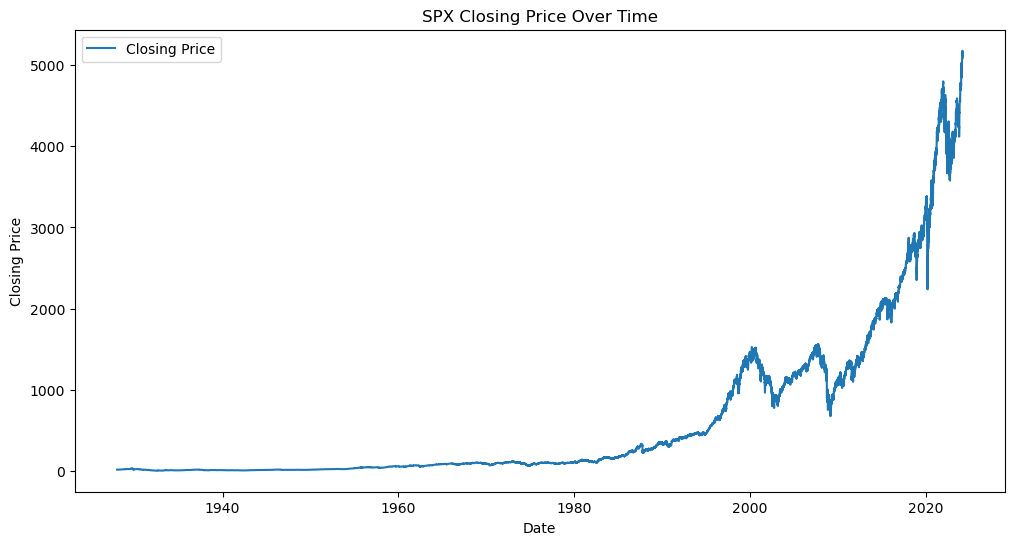

In [9]:
# Main Execution
df = load_data()
df = perform_eda_and_handle_missing(df)

In [10]:
train_df, test_df = train_test_split(df)
df_prophet_train = preprocess_data_for_prophet(train_df)

model = train_prophet_model(df_prophet_train)
forecast = make_predictions(model, df_prophet_train, periods=len(test_df))

22:22:30 - cmdstanpy - INFO - Chain [1] start processing
22:23:21 - cmdstanpy - INFO - Chain [1] done processing


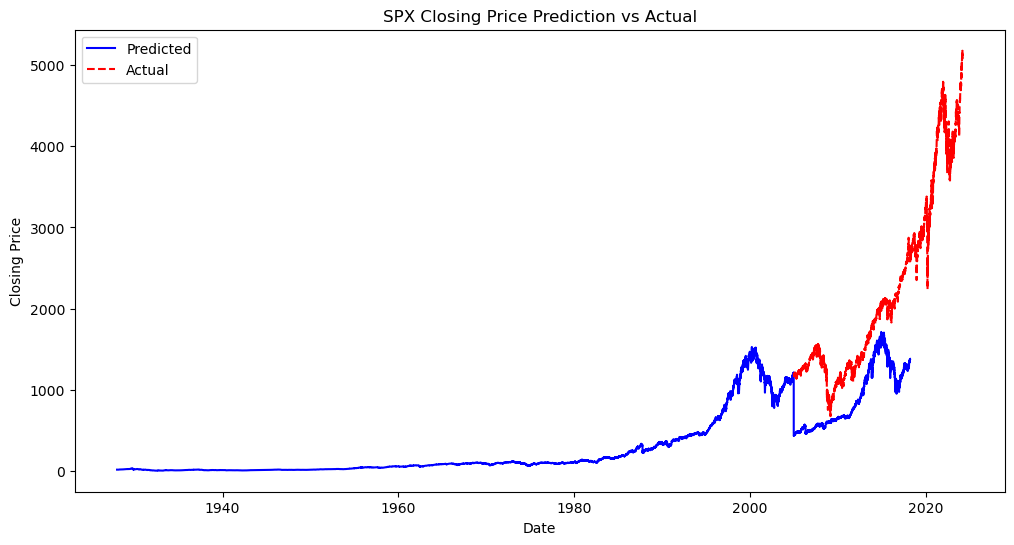

/home/jatinj/.local/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jatinj/.local/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jatinj/.local/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old 

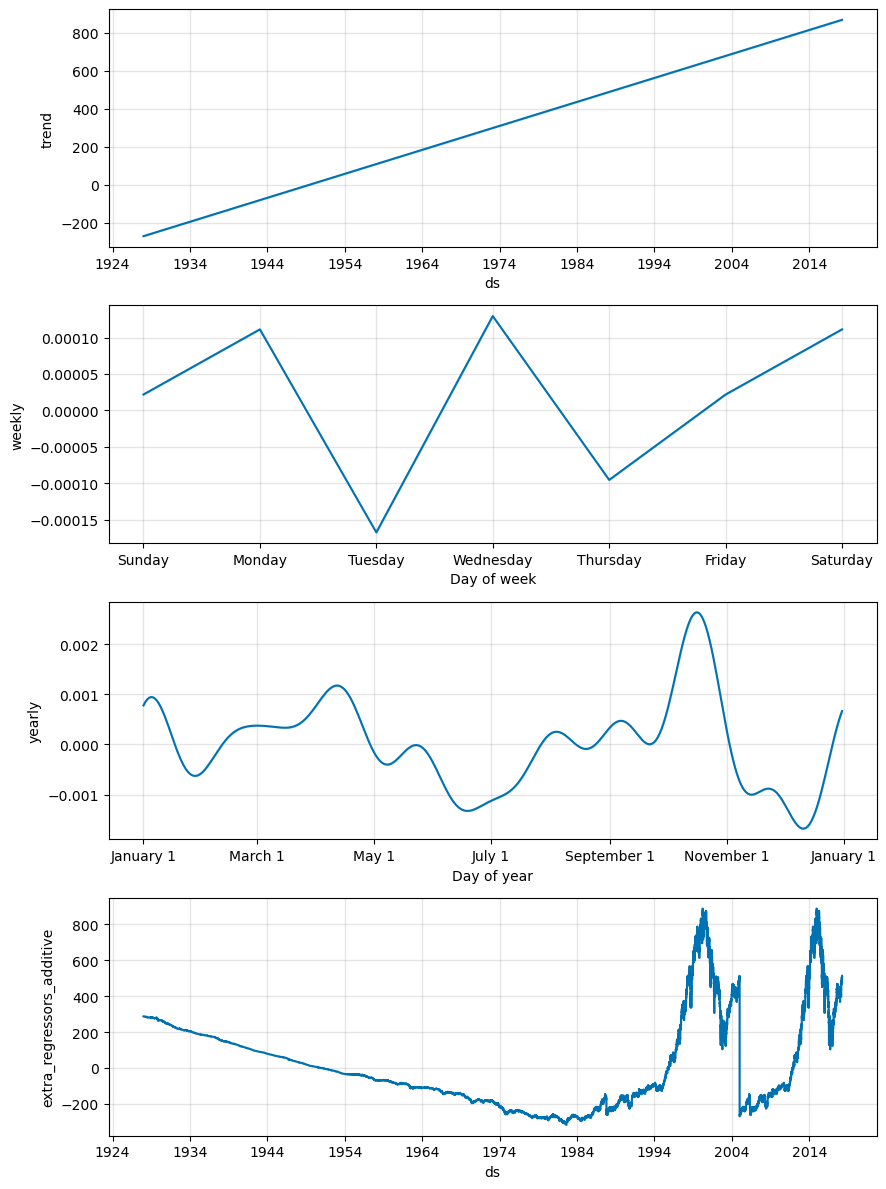

MAE: 666.65
MSE: 526700.11


In [11]:
plot_results(model, forecast, test_df)